# Introduçao

## Prepararando os dados

**Issue relacionada:** [#35](https://github.com/lappis-unb/salic-ml/issues/35)


### Introdução

A **hipótese de que projetos de mesma área e segmentos possuem itens similares** foi negada em relação a métrica definida neste [trabalho](link). Naquele notebook a seguinte métrica foi utilizada para negar esta hipótese:

`p = #(A & B) / #(A | B)`

Onde `A` é o conjunto de itens de um projeto comparado, e `B` é o conjunto de itens do segundo projeto comparado. A hipótese seria verdadeira se e somente se `p >= 0.5`, na média, de um dado subconjunto qualquer da tupla (àrea, segmento).

O valor de `p` é muito sensível a ruídos porque nela cada item do projeto é dado o mesmo peso (por exemplo, peso ou 1). Ou seja, itens muito raros possuem um peso igual a itens muito comuns naquela tupla (area, segmento). Este notebook propõe modificar a métrica acima para confirmar ou negar a hipótese investigada.

### Notação

A notação utilizada acima é explicada [aqui](link).

### Hipóteses

**Hipótese 1:** Projetos de mesma área e segmento possuem conjunto de itens similares

Seja `A` o conjunto de itens de um projeto e `B` o conjunto de itens de outro projeto, ambos os projetos possuindo a mesma área e o mesmo segmento, a hipótese acima afirma que `#(A & B)` deve ser diretamente proporcional ao valor `#(A | B)`.

**Métricas para confirmar (negar) a hipótese 1**


**Métrica 1**



**Recarregar automaticamente os módulos**

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Importando módulos python**

In [28]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from salicml.utils.dates import Dates
from salicml.models.projects import Projects

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

**Carregando os dados da tabela de Projetos**

In [29]:
items_csv_name = 'project_items.csv'
projects_csv = os.path.join(DATA_FOLDER, items_csv_name)

dt_items = pd.read_csv(projects_csv, low_memory=False)
dt_items.head()

,idPronac,PRONAC,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,VlTotalSolicitado,VlUnitarioAprovado,VlTotalAprovado,UfItem,MunicipioItem,Etapa,Area,Segmento,DataProjeto
0,123461,103228,Cartaz,1219,Unidade,180,30.0,6,20.0,3600.0,2.0,360.0,RJ,Rio de Janeiro,3 - Divulgação / Comercialização,3,33,2010-05-06 10:49:13
1,114069,92907,Complementos,2386,Serviço,30,1.0,1,700.0,700.0,700.0,700.0,SC,Florianópolis,2 - Produção / Execução,5,5F,2009-06-24 15:18:51
2,130914,1010654,Cópias e reproduções,1006,Unidade,60,2.0,100,20.0,4000.0,20.0,4000.0,SP,Santos,2 - Produção / Execução,2,88,2010-11-03 16:02:04
3,134008,110805,Banner/faixa adesiva/faixa de lona/saia de pal...,2743,Semana,120,1.0,1,1000.0,1000.0,1000.0,1000.0,SP,São Paulo,3 - Divulgação / Comercialização,3,31,2011-02-01 12:10:08
4,114069,92907,Preparo do solo para plantio,2557,Metro 3,60,200.0,1,40.0,8000.0,40.0,8000.0,SC,Florianópolis,2 - Produção / Execução,5,5F,2009-06-24 15:18:51


### Filtrando os dados

É conhecido que dados muito antigos (de 1992, por exemplo) podem ser inconsistentes, então vamos filtrar os dados a partir de uma data de início.

In [30]:
from datetime import datetime

START_DATE = datetime(day=1, month=1, year=2013)

date_column = 'DataProjeto'
dt_items[date_column] = pd.to_datetime(dt_items[date_column], format = Dates.DATE_INPUT_FORMAT)

dt_items = dt_items[dt_items.loc[:, date_column] >= START_DATE]
print(min(dt_items[date_column]))
dt_items.head()

2013-01-02 10:59:07


,idPronac,PRONAC,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,VlTotalSolicitado,VlUnitarioAprovado,VlTotalAprovado,UfItem,MunicipioItem,Etapa,Area,Segmento,DataProjeto
8,202095,160506,Material de consumo,2719,Verba,365,1.0,1,5000.0,5000.0,5000.0,5000.0,MT,Cuiabá,4 - Custos / Administrativos,6,6F,2016-02-25 17:57:15
533,178933,146032,Hospedagem sem alimentação,130,Dia,4,4.0,3,180.0,2160.0,180.0,2160.0,MG,Belo Horizonte,2 - Produção / Execução,1,12,2014-04-11 18:50:56
836,178933,146032,Transporte Local / Locação de Automóvel / Comb...,134,Verba,4,1.0,1,500.0,500.0,500.0,500.0,PB,João Pessoa,2 - Produção / Execução,1,12,2014-04-11 18:50:56
1894,202095,160506,Sítio de Internet - Hospedagem,2601,Verba,365,1.0,1,1068.0,1068.0,1068.0,1068.0,MT,Cuiabá,1 - Pré-Produção / Preparação,6,6F,2016-02-25 17:57:15
2040,202095,160506,Webdesigner,3731,Projeto,1,1.0,1,10000.0,10000.0,10000.0,10000.0,MT,Cuiabá,1 - Pré-Produção / Preparação,6,6F,2016-02-25 17:57:15


# Explorando os dados

Explorar rapidamente os dados a fim de obter insights.

**Dados básicos**

In [31]:
dt_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232336 entries, 8 to 2001716
Data columns (total 18 columns):
idPronac                1232336 non-null int64
PRONAC                  1232336 non-null int64
Item                    1232336 non-null object
idPlanilhaItens         1232336 non-null int64
Unidade                 1232336 non-null object
QtDias                  1232336 non-null int64
QtItem                  1232336 non-null float64
nrOcorrencia            1232336 non-null int64
VlUnitarioSolicitado    1180077 non-null float64
VlTotalSolicitado       1232336 non-null float64
VlUnitarioAprovado      1232336 non-null float64
VlTotalAprovado         1232336 non-null float64
UfItem                  1232336 non-null object
MunicipioItem           1232336 non-null object
Etapa                   1232336 non-null object
Area                    1232336 non-null int64
Segmento                1232336 non-null object
DataProjeto             1232336 non-null datetime64[ns]
dtypes: datetime

**Identificando se um segmento pode estar em mais de uma área**

In [32]:
from salicml.models.project_items import ProjectItems
from salicml.utils.utils import debug

project_items = ProjectItems(dt_items)

In [33]:
all_areas = project_items.all_areas()
all_segments = project_items.all_segments()

for segment in all_segments:
    rows = dt_items[dt_items.Segmento == segment]
    areas = rows['Area'].unique()
    
    if areas.size > 1:
        print('Segmento: {}'.format(segment))
        print('Areas: {}'.format(areas))
        print('\n')
    

Segmento: 32
Areas: [3 1]




Para o segmento **32** há projetos entre as àreas `(3, 1)`. Portanto não podemos considerar que um segmento pertence a uma única área.

In [34]:
ID_PRONAC = 'idPronac'

**Testando a hipótese em cima de uma única tupla**

A tupla de (area, segmento) que possui o maior número de projetos é a tupla `(1, '11')`, segundo este [trabalho](link). Vamos testar, inicialmente, a hipótese em cima deste conjunto de projetos.



In [35]:
AREA, SEGMENTO = ProjectItems.AREA, ProjectItems.SEGMENTO
area_segment = (1, '11')
area_and_segment = (dt_items[SEGMENTO] == area_segment[1])
area_and_segment &= (dt_items[AREA] == area_segment[0])
items_area = dt_items.loc[area_and_segment]
display(items_area.head(1))

print('(area, segmento) = {}'.format(area_segment))
print('items_area.len = {}'.format(len(items_area.index)))

,idPronac,PRONAC,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,VlTotalSolicitado,VlUnitarioAprovado,VlTotalAprovado,UfItem,MunicipioItem,Etapa,Area,Segmento,DataProjeto
5419,159994,130623,Material efeito especial,1101,Dia,10,1.0,10,200.0,2000.0,200.0,2000.0,ES,Vila Velha,2 - Produção / Execução,1,11,2013-01-21 13:55:03


(area, segmento) = (1, '11')
items_area.len = 347321


In [36]:
ID_ITEM = 'idPlanilhaItens'
counts = np.unique(items_area[ID_ITEM].values, return_counts=True)
print('counts[0].size = {}'.format(counts[0].size))
print('max(counts[1]) = {}'.format(max(counts[1])))

counts[0].size = 1302
max(counts[1]) = 6775


**Estatísticas básicas sobre o eixo-y do histograma**

In [37]:
display(pd.DataFrame(counts[1]).describe())

,0
count,1302.000000
mean,266.759601
std,760.238078
min,1.000000
25%,2.000000
50%,12.500000
75%,126.000000
max,6775.000000


In [38]:
def plot_bar(y):
    x = np.arange(1, len(y) + 1)
    plt.bar(x, y, align='center')
    plt.xlabel('Id do item')
    plt.ylabel('Número de ocorrências do item')
    plt.title('Histograma de ocorrência de itens em projetos aprovados')
    plt.show()

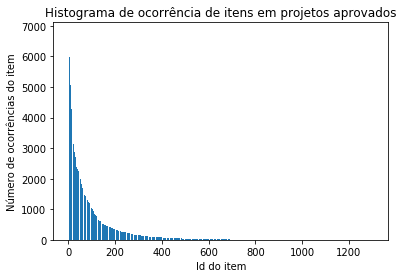

In [39]:
from operator import itemgetter

ids_count = list(zip(*counts))
ids_count.sort(key=itemgetter(1), reverse=True)
x, y = zip(*ids_count)
y = np.array(y)
plot_bar(y)

### Sobre o gráfico acima

O eixo x representa uma "normalização" do id dos itens, pois os ids dos itens não necessariamente formam uma permutação de `[1, n]`. Os valores do eixo y foram ordenados em decrescente já que a ordem dos itens não interessa e o objetivo do notebook é investigar os itens mais frequentes. Também é importante comentar que o histograma acima assume que para uma dada planilha orçamentária há apenas uma linha por tipo (id) do item por projeto (idPronac).

### Repetindo o gráfico mas tirando valores de y que estão abaixo do percentile


,0
count,1302.000000
mean,266.759601
std,760.238078
min,1.000000
25%,2.000000
50%,12.500000
75%,126.000000
max,6775.000000


percentile = 12.5


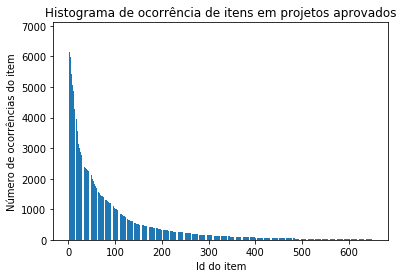

In [40]:
PERCENTILE = 50
percentile = np.percentile(y, PERCENTILE)
display(pd.DataFrame(y).describe())
print('percentile = {}'.format(percentile))

y = [val for val in y if val >= percentile]
plot_bar(y)

**Dando peso aos itens**

Neste passo é assumido que itens mais frequentes devem ter um peso maior que itens menos frequentes. Portanto podemos considerar que o peso de um item `x` é o valor `y` no histograma de contagem dos itens. Agora pode-se calcular a **Métrica 1** utilizando estes pesos e enfim confirmar/negar a **Hipótese 1**.

In [41]:
from collections import Counter

item_weight = Counter(dt_items[ID_ITEM].values)

In [42]:
def get_items_score(items):
    score = sum(item_weight[id] for id in items)
    return score


def get_project_score(id_pronac):
    items = project_items.items(id_pronac)
    score = get_items_score(items)
    return score


def get_projects_weighted_similarity(itens_a, itens_b):
    intersect = np.intersect1d(itens_a, itens_b)
    union = np.union1d(itens_a, itens_b)
    
    numerator = get_items_score(intersect)
    denominator = get_items_score(union)
    
    similarity = numerator / denominator
    
    assert similarity >= 0.0 and similarity <= 1.0
    return similarity


def get_projects_weighted_similarity_min(itens_a, itens_b):
    if itens_a.size > itens_b.size:
        itens_a, itens_b = itens_b, itens_a
        
    intersect = np.intersect1d(itens_a, itens_b)
    numerator = get_items_score(intersect)
    
    denominator = get_items_score(itens_a)
    
    similarity = numerator / denominator
    
    assert similarity >= 0.0 and similarity <= 1.0
    return similarity

In [43]:
p1 = np.random.choice(dt_items[ID_PRONAC].values)
p2 = np.random.choice(dt_items[ID_PRONAC].values)
itens_a = project_items.items(p1)
itens_b = project_items.items(p1)
print('similarity({}, {}) = {}'.format(p1, p2, get_projects_weighted_similarity(itens_a, itens_b)))

similarity(193435, 208023) = 1.0


**Calculando a similaridade entre projetos de áreas (1, '6F')**

Devido o custo computacional das operações na tabela/dataframe, é inviável calcular a similaridade entre todas as combinações tomadas 2 a 2 de todos os projetos da área acima. Um contorno possível é selecionar um subconjunto aleatório destes projetos e testar todas as combinações tomadas 2 a 2 deste subconjunto.

In [44]:
PERCENT =  0.025
pronacs_in_area = items_area[ID_PRONAC].unique()
pronacs = np.random.choice(pronacs_in_area, int(pronacs_in_area.size * PERCENT))
print('sample size = {}'.format(pronacs.size))

sample size = 158


In [45]:
%%time
size = pronacs.size
sims = []
sims_min = []

for i in range(size):
    id1 = pronacs[i]
    items_a = project_items.items(id1, dt=items_area)

    for j in range(i + 1, size):
        id2 = pronacs[j]
        items_b = project_items.items(id2, items_area)
        similarity = project_items.projects_similarity(items_a, items_b)
        similarity_min = project_items.projects_similarity_min(items_a, items_b)
        
        sims.append(similarity)
        sims_min.append(similarity_min)

similarities = np.array(sims, float)
similarities_min = np.array(sims_min, float)


CPU times: user 14.1 s, sys: 11.4 ms, total: 14.1 s
Wall time: 14.1 s


**Resultados da similaridade em relação ao tamanho da união dos conjuntos**

In [46]:


pd.DataFrame(similarities).describe()

,0
count,12403.000000
mean,0.156692
std,0.080735
min,0.000000
25%,0.102041
50%,0.145161
75%,0.195019
max,1.000000


**Resultados da similaridade em relação ao tamanho do menor dos dois conjuntos**

Esta é uma estatística menos rígida na similaridade, e desconsidera o tamanho do maior dos dois juntos O problema disso é que é possível que um projeto com 50 itens tenha uma similaridade de 90% de um projeto com 800 itens, enquanto na métrica em relação ao tamanho da união dos conjuntos, este resultado seria impossível.

In [47]:
pd.DataFrame(similarities_min).describe()

,0
count,12403.000000
mean,0.351556
std,0.140582
min,0.000000
25%,0.250000
50%,0.333333
75%,0.439024
max,1.000000


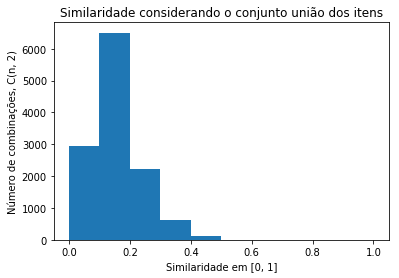

In [48]:
plt.hist(similarities)
plt.title('Similaridade considerando o conjunto união dos itens')
plt.xlabel('Similaridade em [0, 1]')
plt.ylabel('Número de combinações, C(n, 2)')
plt.show()

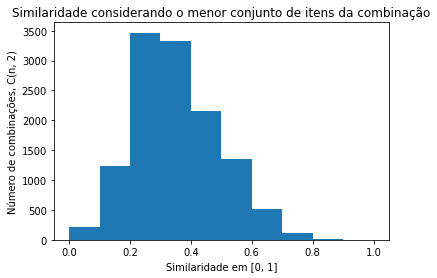

In [49]:
plt.hist(similarities_min)
plt.title('Similaridade considerando o menor conjunto de itens da combinação')
plt.xlabel('Similaridade em [0, 1]')
plt.ylabel('Número de combinações, C(n, 2)')
plt.show()

# Comparação com os resultados da mesma métrica mas sem pesos

**Métrica 1**

In [51]:
%store -r sim_describe
%store -r pronacs_sample
display(sim_describe)

,0
count,12403.000000
mean,0.151303
std,0.080590
min,0.000000
25%,0.092308
50%,0.138462
75%,0.195122
max,0.823529


### Conclusões

Em relação a Métrica 1 (`#(A & B) / #(A | B)`) definida para negar/confirmar a hipótese de que projetos de mesma área e segmento possuem projetos itens similares, podemos concluir que a hipótese foi negada. Pelo menos 75% dos projetos possuem uma similaridade menor que `0.25`, valor menor que o mínimo `0.5` determinado para a hipótese ser confirmada. A maior similaridade encontrada foi de `0.46` de acordo com esta métrica. É possível que as categorias de (Àrea, segmento) não representem adequadamente o que de fato os projetos precisam de itens para executar na prática do projeto, tornando inviável considerar unicamente estas duas variáveis para entender a categoria real de um projeto.

#### Contribuições futuras

A métrica aqui utilizada considera o conjunto de todos os itens de um projeto. Pode ser que considerar itens apenas "significativos" representem melhor a similaridade real dos projetos. As métricas foram calculadas utilizando as labels supervisionadas (oriundas do próprio Salic), pode ser que uma abordagem não-supervisionada atinga resultados melhores sobre esta mesma métrica.